# Tire Degradation Prediction Model - Week 5

## Overview
This notebook implements advanced models to predict tire degradation in Formula 1 races. Since tire degradation is not strictly linear and depends on multiple factors (compound type, track temperature, driving style, etc.), we'll use sequence models like LSTM to capture these complex patterns.

## Approach
1. **Data Exploration**
   - Analyze the relationship between lap times and tire age
   - Visualize performance degradation patterns by compound
   - Determine how to quantify "degradation" (lap time delta or derived metric)

2. **Feature Engineering**
   - Create a derived tire degradation metric
   - Organize data into sequential format for LSTM
   - Normalize features appropriately
   - Create sliding windows of previous laps to predict future performance

3. **Model Development**
   - **Primary Model**: LSTM network to predict degradation trajectory
   - **Alternative Model**: XGBoost with quantile regression for uncertainty estimation

4. **Evaluation & Visualization**
   - Compare predicted vs. actual degradation curves
   - Analyze performance across different compounds and race conditions
   - Create interactive Plotly visualizations of degradation patterns

5. **Implementation Details**
   - Sequence length: 5 laps (input) → predict next 3-5 laps
   - Features: Tire age, compound, lap time trends, fuel load
   - Target: Derived degradation metric or direct lap time prediction

## Expected Outcomes
- Trained model to predict tire performance over extended stints
- Uncertainty bounds for degradation predictions (10th, 50th, 90th percentiles)
- Interactive visualization of degradation curves by compound

---

## 1. Importing Necessary Libraries and Creatind New Directories

In [70]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import os



In [71]:
# Import utility functions from our module
from ML_utils.lap_prediction import compound_colors, compound_names

# Set plot style
plt.style.use('ggplot')
sns.set(style="whitegrid")

# Create output directories if they don't exist
os.makedirs('../../outputs/week5', exist_ok=True)
os.makedirs('../../models/week5', exist_ok=True)

---

## 2. Loading Dataframes

In [72]:
data = pd.read_csv("../../outputs/week3/lap_prediction_data.csv")
print("\nRegular data sample:")
display(data.head())


Regular data sample:


,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,DRSUsed,TeamID,CompoundID,TyreAge,FuelLoad,DriverNumber
0,0,83.935,1.0,256.0,261.0,276.0,275.0,1.0,1.0,0,9,2,1.0,0.9848,1
1,1,80.402,1.0,252.0,257.0,276.0,295.0,1.0,2.0,0,9,2,2.0,0.9697,1
2,2,80.499,1.0,249.0,256.0,276.0,297.0,1.0,3.0,0,9,2,3.0,0.9545,1
3,3,80.346,1.0,255.0,256.0,276.0,300.0,1.0,4.0,0,9,2,4.0,0.9394,1
4,4,80.283,1.0,254.0,256.0,277.0,301.0,1.0,5.0,0,9,2,5.0,0.9242,1


In [73]:
seq_data = pd.read_csv("../../outputs/week3/sequential_lap_prediction_data.csv")
print("\nSequential data sample:")
display(seq_data.head())


Sequential data sample:


,Unnamed: 0.1,Unnamed: 0,LapTime,Stint,SpeedI1,SpeedI2,SpeedFL,SpeedST,Position,LapsSincePitStop,...,Prev_SpeedI2,Prev_SpeedFL,Prev_SpeedST,Prev_TyreAge,LapTime_Delta,SpeedI1_Delta,SpeedI2_Delta,SpeedFL_Delta,SpeedST_Delta,LapTime_Trend
0,1,1.0,80.402,1.0,252.0,257.0,276.0,295.00,1.0,2.0,...,261.0,276.0,275.0,1.0,-3.533,-4.0,-4.0,0.0,20.00,0.000
1,2,2.0,80.499,1.0,249.0,256.0,276.0,297.00,1.0,3.0,...,257.0,276.0,295.0,2.0,0.097,-3.0,-1.0,0.0,2.00,3.630
2,3,3.0,80.346,1.0,255.0,256.0,276.0,300.00,1.0,4.0,...,256.0,276.0,297.0,3.0,-0.153,6.0,0.0,0.0,3.00,-0.250
3,4,4.0,80.283,1.0,254.0,256.0,277.0,301.00,1.0,5.0,...,256.0,276.0,300.0,4.0,-0.063,-1.0,0.0,1.0,1.00,0.090
4,5,5.0,80.402,1.0,255.0,253.0,276.0,309.85,1.0,6.0,...,256.0,277.0,301.0,5.0,0.119,1.0,-3.0,-1.0,8.85,0.182


In [74]:
# Display basic information
print("Basic dataset information:")
print(f"Regular data shape: {data.shape}")
print(f"Sequential data shape: {seq_data.shape}")

Basic dataset information:
Regular data shape: (1180, 15)
Sequential data shape: (1118, 28)


---

## 3. Locating Tire Related Columns


In [75]:
# Check for tire-related columns
tire_columns = ['CompoundID', 'TyreAge']
print(f"\nTire-related columns: {tire_columns}")


Tire-related columns: ['CompoundID', 'TyreAge']


In [76]:
# Summary statistics for tire-related columns
print("\nTire-related statistics:")
display(data[tire_columns].describe())


Tire-related statistics:


,CompoundID,TyreAge
count,1180.000000,1180.000000
mean,2.188136,13.760169
std,0.800887,8.002074
min,1.000000,1.000000
25%,2.000000,7.000000
50%,2.000000,13.000000
75%,3.000000,19.000000
max,3.000000,50.000000


---

## 4. Compound Mappings

In [77]:
# Print compound mappings for reference
print("\nCompound mappings:")
print(f"Compound names: {compound_names}")
print(f"Compound colors: {compound_colors}")


Compound mappings:
Compound names: {1: 'SOFT', 2: 'MEDIUM', 3: 'HARD', 4: 'INTERMEDIATE', 5: 'WET'}
Compound colors: {1: 'red', 2: 'yellow', 3: 'gray', 4: 'green', 5: 'blue'}


---

## 5. Analyzing Relationship between Tire Age and Lap Time by compound

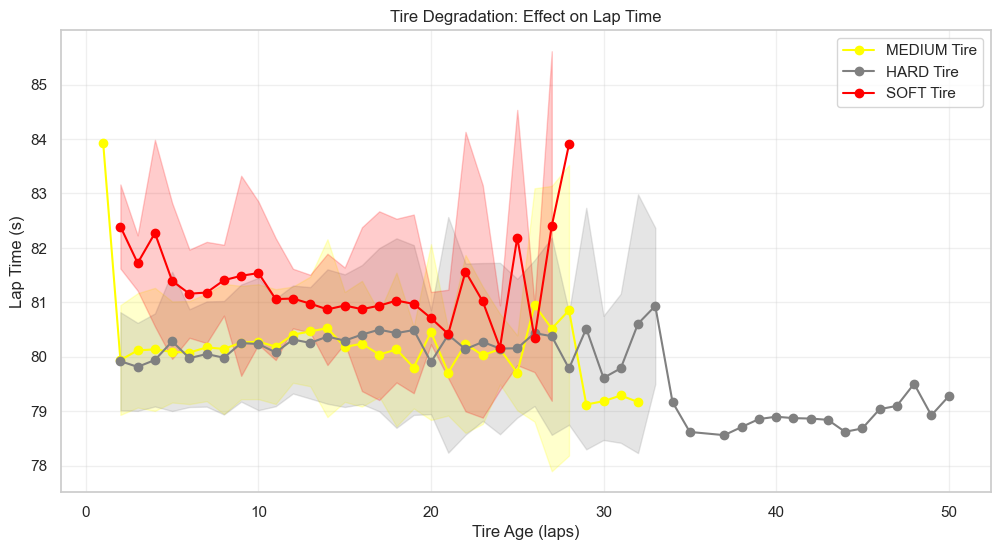

In [78]:
# Visualize the relationship between tire age and lap time by compound
plt.figure(figsize=(12, 6))

# Group by compound and tire age
for compound_id in data['CompoundID'].unique():
    subset = data[data['CompoundID'] == compound_id]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')['LapTime'].agg(['mean', 'std', 'count']).reset_index()
    
    # Only plot if we have enough data points
    if len(agg_data) > 1:
        color = compound_colors.get(compound_id, 'black')
        compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
        
        plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
                 color=color, label=f'{compound_name} Tire')
        
        # Add error bands (standard deviation)
        if 'std' in agg_data.columns:
            plt.fill_between(agg_data['TyreAge'], 
                            agg_data['mean'] - agg_data['std'], 
                            agg_data['mean'] + agg_data['std'],
                            color=color, alpha=0.2)

plt.xlabel('Tire Age (laps)')
plt.ylabel('Lap Time (s)')
plt.title('Tire Degradation: Effect on Lap Time')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_deg_curve.png')
plt.show()

---

## 6. Exploring Lap Times Deltas and Tire Ages

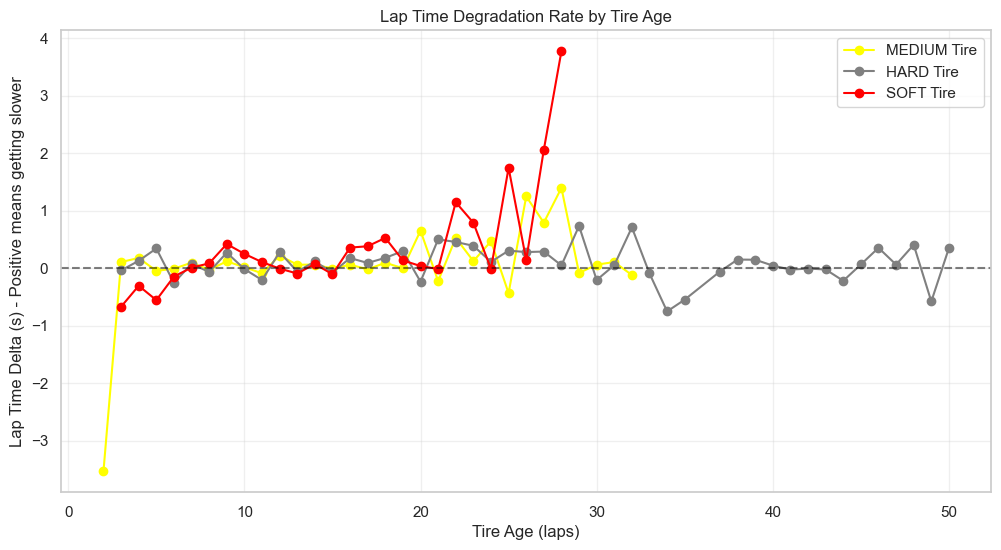

In [79]:
# Explore lap time deltas as tire ages
if 'LapTime_Delta' in seq_data.columns:
    plt.figure(figsize=(12, 6))
    
    for compound_id in seq_data['CompoundID'].unique():
        subset = seq_data[seq_data['CompoundID'] == compound_id]
        
        # Aggregate by tire age
        agg_data = subset.groupby('TyreAge')['LapTime_Delta'].mean().reset_index()
        
        # Only plot if we have enough data points
        if len(agg_data) > 1:
            color = compound_colors.get(compound_id, 'black')
            compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
            
            plt.plot(agg_data['TyreAge'], agg_data['LapTime_Delta'], 'o-', 
                     color=color, label=f'{compound_name} Tire')
    
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.xlabel('Tire Age (laps)')
    plt.ylabel('Lap Time Delta (s) - Positive means getting slower')
    plt.title('Lap Time Degradation Rate by Tire Age')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig('../../outputs/week5/tire_deg_rate.png')
    plt.show()

---

## 7. Exploring if Tire Age affects Speed in different Sectors

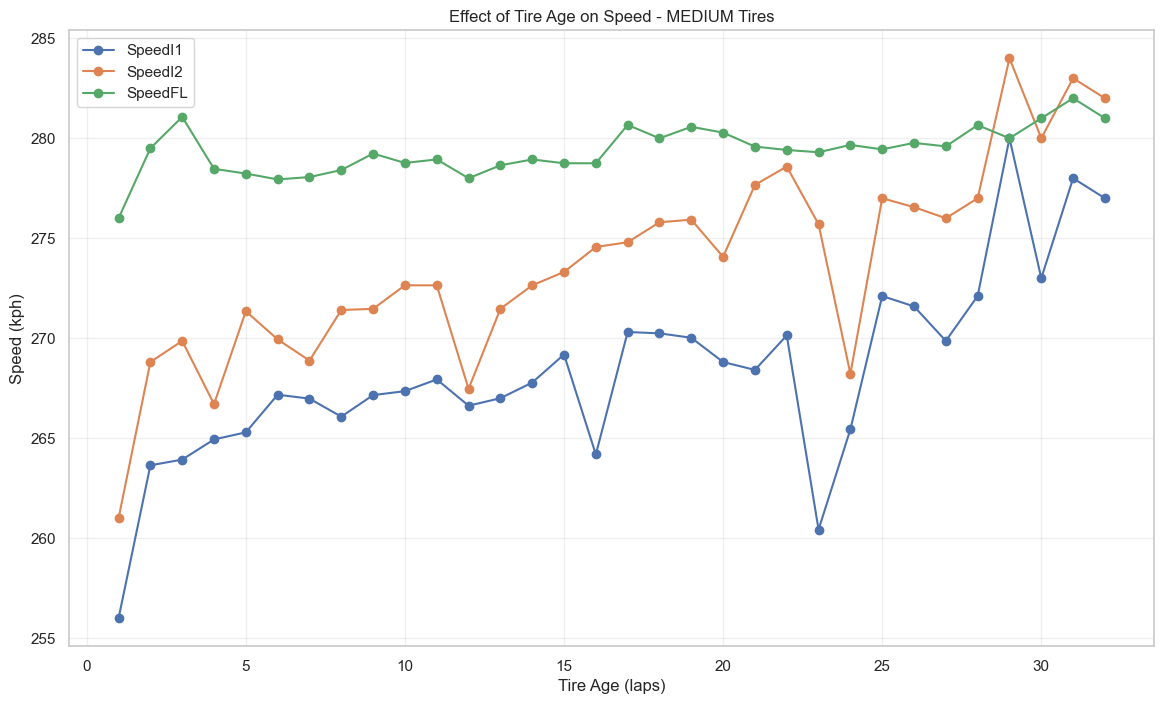

In [80]:
# Look at how tire age affects speed in different sectors
speed_columns = ['SpeedI1', 'SpeedI2', 'SpeedFL']

plt.figure(figsize=(14, 8))
for speed_col in speed_columns:
    # Focus on compound ID 2 (Medium) since that's what we have in the data
    subset = data[data['CompoundID'] == 2]
    
    # Aggregate by tire age
    agg_data = subset.groupby('TyreAge')[speed_col].mean().reset_index()
    
    if len(agg_data) > 1:
        plt.plot(agg_data['TyreAge'], agg_data[speed_col], 'o-', 
                 label=f'{speed_col}')

plt.xlabel('Tire Age (laps)')
plt.ylabel('Speed (kph)')
plt.title(f'Effect of Tire Age on Speed - {compound_names.get(2)} Tires')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/tire_age_speed_effect.png')
plt.show()

---

## 8. Creating Tire Degradation Metrics

For being able to predict tyre degradation more effectively, a good option can be generate more variables with the current data that we have. Therefore, I´ll add this new variables:

## Disclaimer: importance of fuel load.

After making the cells and looking at the data, some tires shows positive degradation. That means that lap times are descending instead of going up. This is caused due to the less amount of fuel during the race. Therefore, I need to **create an adjusted lap time** that takes into account this fuel factor before creating our prediction models. 

Then, I will create this variable and then adjust the plots and variable calculation for fitting this feature.

*NOTE*: fuel burn calculation and impact will be calculated according to this articles: 

- [BBC Sport Weight Reduction](https://www.bbc.com/sport/articles/cv2g715dkk1o#:~:text=A%201.5kg%20reduction%20in,so%20over%20a%20race%20distance.)

- [Fuel Correction Analysis, Medium](https://medium.com/@umakschually/fuel-correction-29ccd98ae62b#:~:text=Rule%20of%20thumb%20is%20that,tyre%20age%20or%20anything%20else.)

#### 1. Absolute Tire Degradation (TireDegAbsolute)

Its objective is to **measure how much seconds is the actual lap time slower, compared with the baseline** (new tires or with the less degradation possible, for instance, only 2 laps).

**Positive values** implie degradation (car is getting slower). As I said, it would be measured in **seconds**.

- *Utility*:
    - Allows knowing the direct impact on lap time.
    - Helps to determine the *cross point* when a pit stop becomes an advantage.
    - Fundamental for strategic calculus, as teams work with absolute times.
    - Helps us answering the following: **How many seconds are we losing per lap with degradation?**

#### 2. Tire Degradation Percentage 

It expresses degradation as an **augmenting percentage** to base time. For instance, 2% means the car is 2% slower than with new tires.

- *Utility*:
    - Allows more intuitive comparisons between different conditions.
    - Normalizes the data for more clear comparisons between tires.
    - Helps us aswering the following:**Which compound maintains better its relative performance?**

#### 3. Degradation Rate

Means how much time increases per lap with each aditional lap. Represents the first derivative of degradation curve. 

- *Utility:*
    - Allows knowing if degradation is lineal, progressive or if it stabilizes.
    - Crucial for estimating optimum pit stop window during races.
    - Allows anticipating future compound´s behaviour.
    - Helps us answering the following: **Degradation is getting worse or it is stabilizing?**.



---

### Calculating Lap Time Improvement Per Lap

In [81]:
# Crear métricas de degradación ajustadas usando directamente la mejora de tiempo por vuelta
# Tiempo que mejora cada vuelta debido a la reducción de combustible
LAP_TIME_IMPROVEMENT_PER_LAP = 0.055  # segundos por vuelta (punto medio de 0.05-0.06s)

# Create a DataFrame to store all results with fuel adjustment
tire_deg_data = pd.DataFrame()

# Process each compound separately
for compound_id in data['CompoundID'].unique():
    compound_name = compound_names.get(compound_id, f"Unknown ({compound_id})")
    print(f"Processing {compound_name} tires (ID: {compound_id})...")
    
    # Filter for this compound
    compound_data = data[data['CompoundID'] == compound_id].copy()
    
    # Sort by TyreAge to see the degradation trend
    compound_data = compound_data.sort_values('TyreAge')
    
    # Check if we have enough data
    if len(compound_data) < 5:
        print(f"  Not enough data for {compound_name} tires, skipping")
        continue
    
    # Find baseline information
    if 1 in compound_data['TyreAge'].values:
        # Get baseline data (TyreAge=1)
        baseline_data = compound_data[compound_data['TyreAge'] == 1]
        baseline_lap_time = baseline_data['LapTime'].mean()
        baseline_tire_age = 1
    else:
        # If no 'new tire' laps, use the minimum TyreAge available
        min_age = compound_data['TyreAge'].min()
        baseline_data = compound_data[compound_data['TyreAge'] == min_age]
        baseline_lap_time = baseline_data['LapTime'].mean()
        baseline_tire_age = min_age
        print(f"  No laps with new tires for {compound_name}, using TyreAge={min_age} as baseline")
    
    # Calculate fuel adjustment directly based on laps from baseline
    compound_data['LapsFromBaseline'] = compound_data['TyreAge'] - baseline_tire_age
    compound_data['FuelEffect'] = compound_data['LapsFromBaseline'] * LAP_TIME_IMPROVEMENT_PER_LAP
    
    # Calculate fuel-adjusted lap time
    compound_data['FuelAdjustedLapTime'] = compound_data['LapTime'] + compound_data['FuelEffect']
    
    # Calculate traditional degradation metrics
    compound_data['TireDegAbsolute'] = compound_data['LapTime'] - baseline_lap_time
    compound_data['TireDegPercent'] = (compound_data['LapTime'] / baseline_lap_time - 1) * 100
    
    # Calculate fuel-adjusted degradation metrics
    baseline_adjusted_lap_time = baseline_lap_time  # For new tires, no adjustment needed
    compound_data['FuelAdjustedDegAbsolute'] = compound_data['FuelAdjustedLapTime'] - baseline_adjusted_lap_time
    compound_data['FuelAdjustedDegPercent'] = (compound_data['FuelAdjustedLapTime'] / baseline_adjusted_lap_time - 1) * 100
    
    # Add compound info for later aggregation
    compound_data['CompoundName'] = compound_name
    
    # Add to the combined DataFrame
    tire_deg_data = pd.concat([tire_deg_data, compound_data])
    
    # Calculate maximum laps and total fuel effect
    max_laps = compound_data['TyreAge'].max() - baseline_tire_age
    total_fuel_effect = max_laps * LAP_TIME_IMPROVEMENT_PER_LAP
    
    print(f"  Baseline lap time for {compound_name}: {baseline_lap_time:.3f}s")
    print(f"  Maximum laps from baseline: {max_laps:.0f}")
    print(f"  Estimated total fuel benefit: ~{total_fuel_effect:.2f}s")
    print(f"  Processed {len(compound_data)} laps with {compound_name} tires")

# Display comparison between regular and fuel-adjusted metrics
print("\nComparison of regular vs. fuel-adjusted metrics (sample):")
sample_comparison = tire_deg_data.groupby(['CompoundName', 'TyreAge'])[
    ['TireDegAbsolute', 'FuelAdjustedDegAbsolute', 'FuelEffect']
].mean().reset_index()
display(sample_comparison.head(10))


Processing MEDIUM tires (ID: 2)...
  Baseline lap time for MEDIUM: 83.935s
  Maximum laps from baseline: 31
  Estimated total fuel benefit: ~1.71s
  Processed 382 laps with MEDIUM tires
Processing HARD tires (ID: 3)...
  No laps with new tires for HARD, using TyreAge=2.0 as baseline
  Baseline lap time for HARD: 79.917s
  Maximum laps from baseline: 48
  Estimated total fuel benefit: ~2.64s
  Processed 510 laps with HARD tires
Processing SOFT tires (ID: 1)...
  No laps with new tires for SOFT, using TyreAge=2.0 as baseline
  Baseline lap time for SOFT: 82.392s
  Maximum laps from baseline: 26
  Estimated total fuel benefit: ~1.43s
  Processed 288 laps with SOFT tires

Comparison of regular vs. fuel-adjusted metrics (sample):


,CompoundName,TyreAge,TireDegAbsolute,FuelAdjustedDegAbsolute,FuelEffect
0,HARD,2.0,2.243819e-15,2.243819e-15,0.000
1,HARD,3.0,-1.049184e-01,-4.991842e-02,0.055
2,HARD,4.0,2.213158e-02,1.321316e-01,0.110
3,HARD,5.0,3.637316e-01,5.287316e-01,0.165
4,HARD,6.0,5.582206e-02,2.758221e-01,0.220
5,HARD,7.0,1.311554e-01,4.061554e-01,0.275
6,HARD,8.0,6.310777e-02,3.931078e-01,0.330
7,HARD,9.0,3.324887e-01,7.174887e-01,0.385
8,HARD,10.0,3.162982e-01,7.562982e-01,0.440
9,HARD,11.0,1.606816e-01,6.556816e-01,0.495


---

### Plotting the Diferrence between regular and Fuel Adjusted Degradation

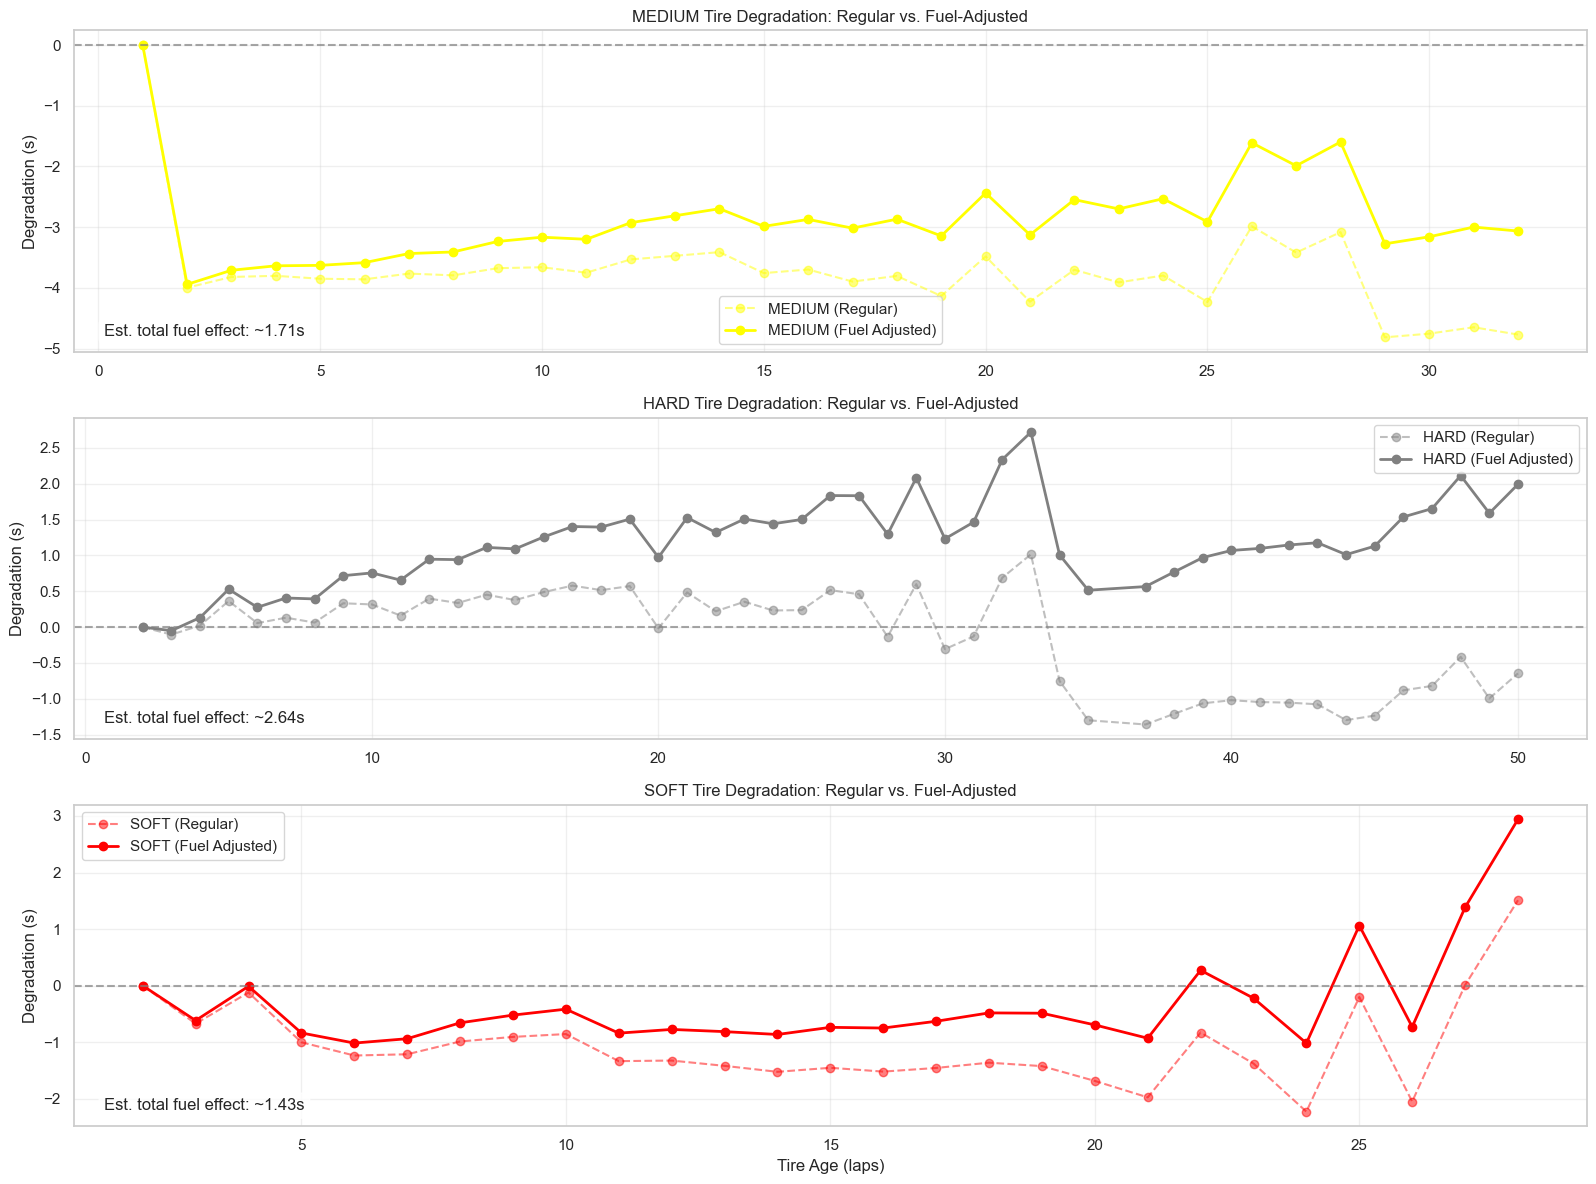

In [82]:
# Create a comparison of regular vs fuel-adjusted degradation
plt.figure(figsize=(16, 12))
compound_ids = tire_deg_data['CompoundID'].unique()
# Loop through the compounds to create comparison plots
for i, compound_id in enumerate(compound_ids):
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Calculate means for regular and adjusted degradation
    reg_agg = compound_subset.groupby('TyreAge')['TireDegAbsolute'].mean()
    adj_agg = compound_subset.groupby('TyreAge')['FuelAdjustedDegAbsolute'].mean()
    
    # Create subplot
    plt.subplot(len(compound_ids), 1, i+1)
    
    # Plot regular degradation
    plt.plot(reg_agg.index, reg_agg.values, 'o--', 
             color=color, alpha=0.5, label=f'{compound_name} (Regular)')
    
    # Plot fuel-adjusted degradation
    plt.plot(adj_agg.index, adj_agg.values, 'o-', 
             color=color, linewidth=2, label=f'{compound_name} (Fuel Adjusted)')
    
    plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
    plt.ylabel('Degradation (s)')
    plt.title(f'{compound_name} Tire Degradation: Regular vs. Fuel-Adjusted')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Anotar la diferencia total estimada del efecto combustible
    min_lap = reg_agg.index.min()
    max_lap = reg_agg.index.max()
    total_laps = max_lap - min_lap
    total_fuel_effect = total_laps * LAP_TIME_IMPROVEMENT_PER_LAP
    plt.annotate(f"Est. total fuel effect: ~{total_fuel_effect:.2f}s", 
                 xy=(0.02, 0.05), xycoords='axes fraction',
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", alpha=0.8))
    
    if i == len(compound_ids)-1:  # Solo añadir etiqueta x para el subgráfico inferior
        plt.xlabel('Tire Age (laps)')

plt.tight_layout()
plt.savefig('../../outputs/week5/regular_vs_adjusted_comparison.png')
plt.show()


---

### 8.1 Absolute Tire Degradation

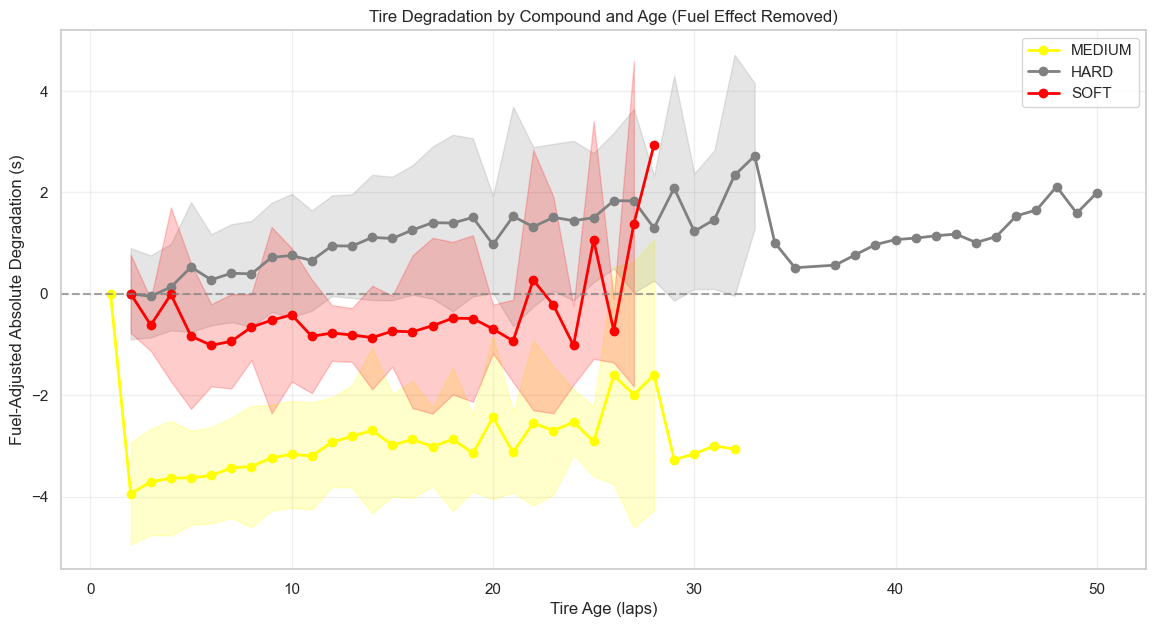

In [83]:
# Visualize the fuel-adjusted absolute degradation
plt.figure(figsize=(14, 7))
compound_ids = tire_deg_data['CompoundID'].unique()

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['FuelAdjustedDegAbsolute'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Absolute Degradation (s)')
plt.title('Tire Degradation by Compound and Age (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fuel_adjusted_deg_by_compound.png')
plt.show()

---

### 8.2 Tire Degradation Percentage

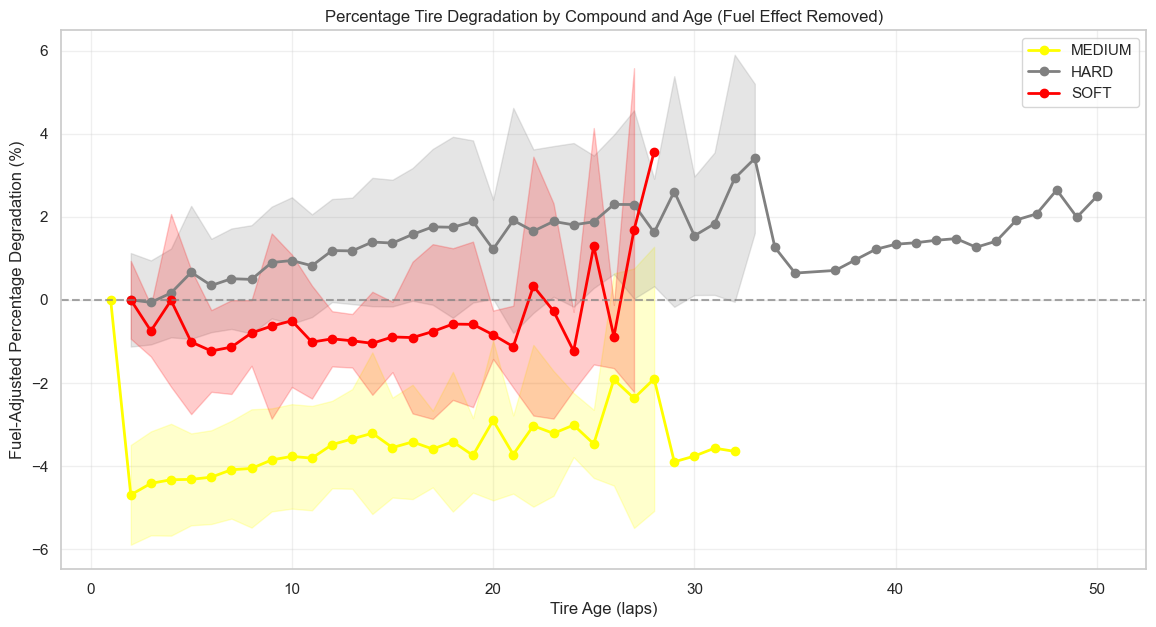

In [84]:
# Visualize the fuel-adjusted percentage degradation
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Aggregate data for line plot
    agg_data = compound_subset.groupby('TyreAge')['FuelAdjustedDegPercent'].agg(['mean', 'std']).reset_index()
    
    # Plot mean line
    plt.plot(agg_data['TyreAge'], agg_data['mean'], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')
    
    # Add error bands if we have standard deviation
    if 'std' in agg_data.columns and not agg_data['std'].isnull().all():
        plt.fill_between(agg_data['TyreAge'], 
                        agg_data['mean'] - agg_data['std'], 
                        agg_data['mean'] + agg_data['std'],
                        color=color, alpha=0.2)

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Percentage Degradation (%)')
plt.title('Percentage Tire Degradation by Compound and Age (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fuel_adjusted_deg_percent_by_compound.png')
plt.show()

---

### 8.3 Tire Degradation Rate

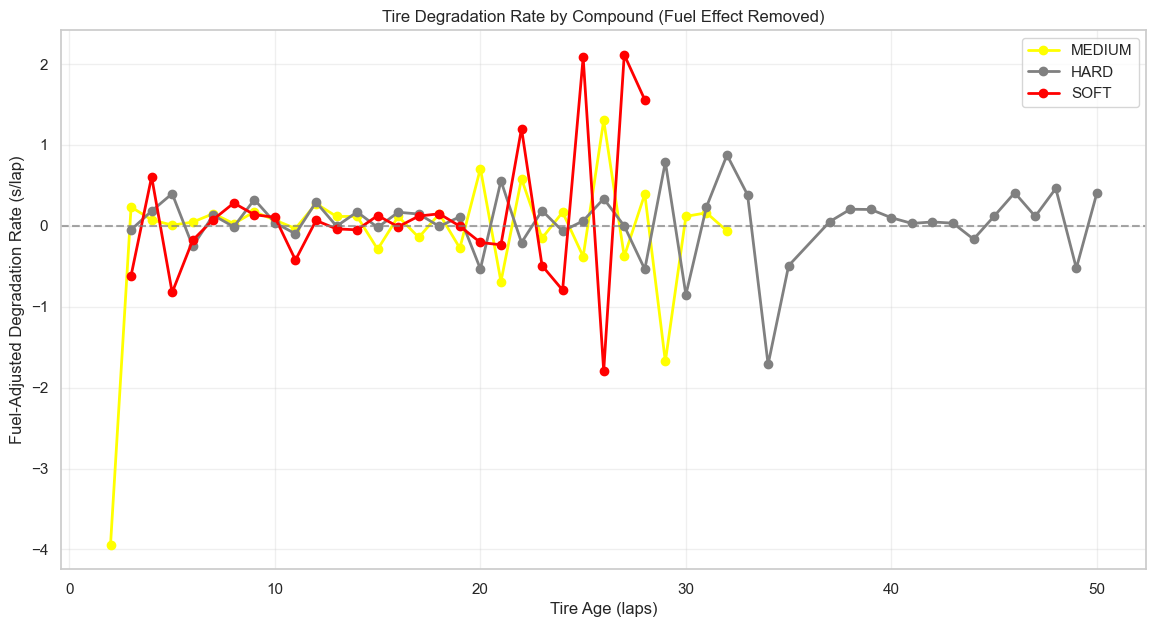

In [85]:
# Calculate fuel-adjusted lap-by-lap degradation rate
plt.figure(figsize=(14, 7))

for compound_id in compound_ids:
    compound_subset = tire_deg_data[tire_deg_data['CompoundID'] == compound_id]
    color = compound_colors.get(compound_id, 'black')
    compound_name = compound_names.get(compound_id, f'Unknown ({compound_id})')
    
    # Calculate average fuel-adjusted lap time by tire age
    avg_laptimes = compound_subset.groupby('TyreAge')['FuelAdjustedLapTime'].mean()
    
    # Calculate lap-by-lap degradation rate
    deg_rates = avg_laptimes.diff()
    
    # Plot the degradation rate (change in seconds per lap)
    plt.plot(deg_rates.index[1:], deg_rates.values[1:], 'o-', 
             color=color, linewidth=2, label=f'{compound_name}')

plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Tire Age (laps)')
plt.ylabel('Fuel-Adjusted Degradation Rate (s/lap)')
plt.title('Tire Degradation Rate by Compound (Fuel Effect Removed)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('../../outputs/week5/fuel_adjusted_deg_rate_by_compound.png')
plt.show()

## Key Findings

#### Medium Tire (Yellow).

- The fuel effect was masking significantly degradation. With the adjustment, mroe degradation can be seen.

- They offer the best initial advantage (-4 seconds), that stabilizes in -3 seconds until aproximately lap 30.

- Total fuel impact is about 1.73 seconds faster at the end of the stint.

- They represent the best balance between performance and durability.

#### Hard Tire (Gray)

- Fuel effect made an stabilization ilusion and even improvement. The adjust reveals a constant and progressive degradation that goes up to +2seconds.

- Fuel effect on this tires are the biggest, with 2.64 fastet.

- Degradation rate is more stable and predictable, making them ideal for long stints.

#### Soft Tire (Red)

- There is a bigger volatile effect that it seemed without fuel effect.
- Erratic behaviour and big fluctuations after lap 20.
- Highly unpredictable and dramatically fluctating, specially after lap 20, with extreme degradation peaks of +2 seconds slower per lap.

### Detected Turning Points

- *SOFT*: show a cliff degradation over 20 laps.
- *MEDIUM*: change in pattern near lap 30.
- *HARD*: show a degradation increase after lap 40.


### Good Conclussions for predictive model. 

1. Fuel adjustment was essential for identifying true degradation.
2. Each compound shows unique patterns that can be useful for the model:
    - Soft tire as high volatile with critic points of sudden degradation.
    - Medium tire has a fast fall followed by stabilization.
    - Hard tire with slow but continous degradation.

3. Identified turning points are going to be crucial parameters for the LSTM or XgBoost, as they show critic moments for pit stop strategies.

---

## 9. Correlation Analysis: Tire-Related Factors with Lap Time

In [ ]:
# Invert dictionary to apply conversion to compound names to numbers 
compound_names_inv = {value: key for key, value in compound_names.items()}
# Replace the names with its according numbers
tire_deg_data["CompoundName"] = tire_deg_data["CompoundName"].replace(compound_names_inv)

# We can eliminate this column as it does not provide any information
tire_deg_data = tire_deg_data.drop('Unnamed: 0', axis=1)
# Also eliminate LapTime and keep the times applied the fuel load?
# tire_deg_data = tire_deg_data.drop("LapTime", axis = 1)

C:\Users\victo\AppData\Local\Temp\ipykernel_19872\1854544892.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tire_deg_data["CompoundName"] = tire_deg_data["CompoundName"].replace(compound_names_inv)


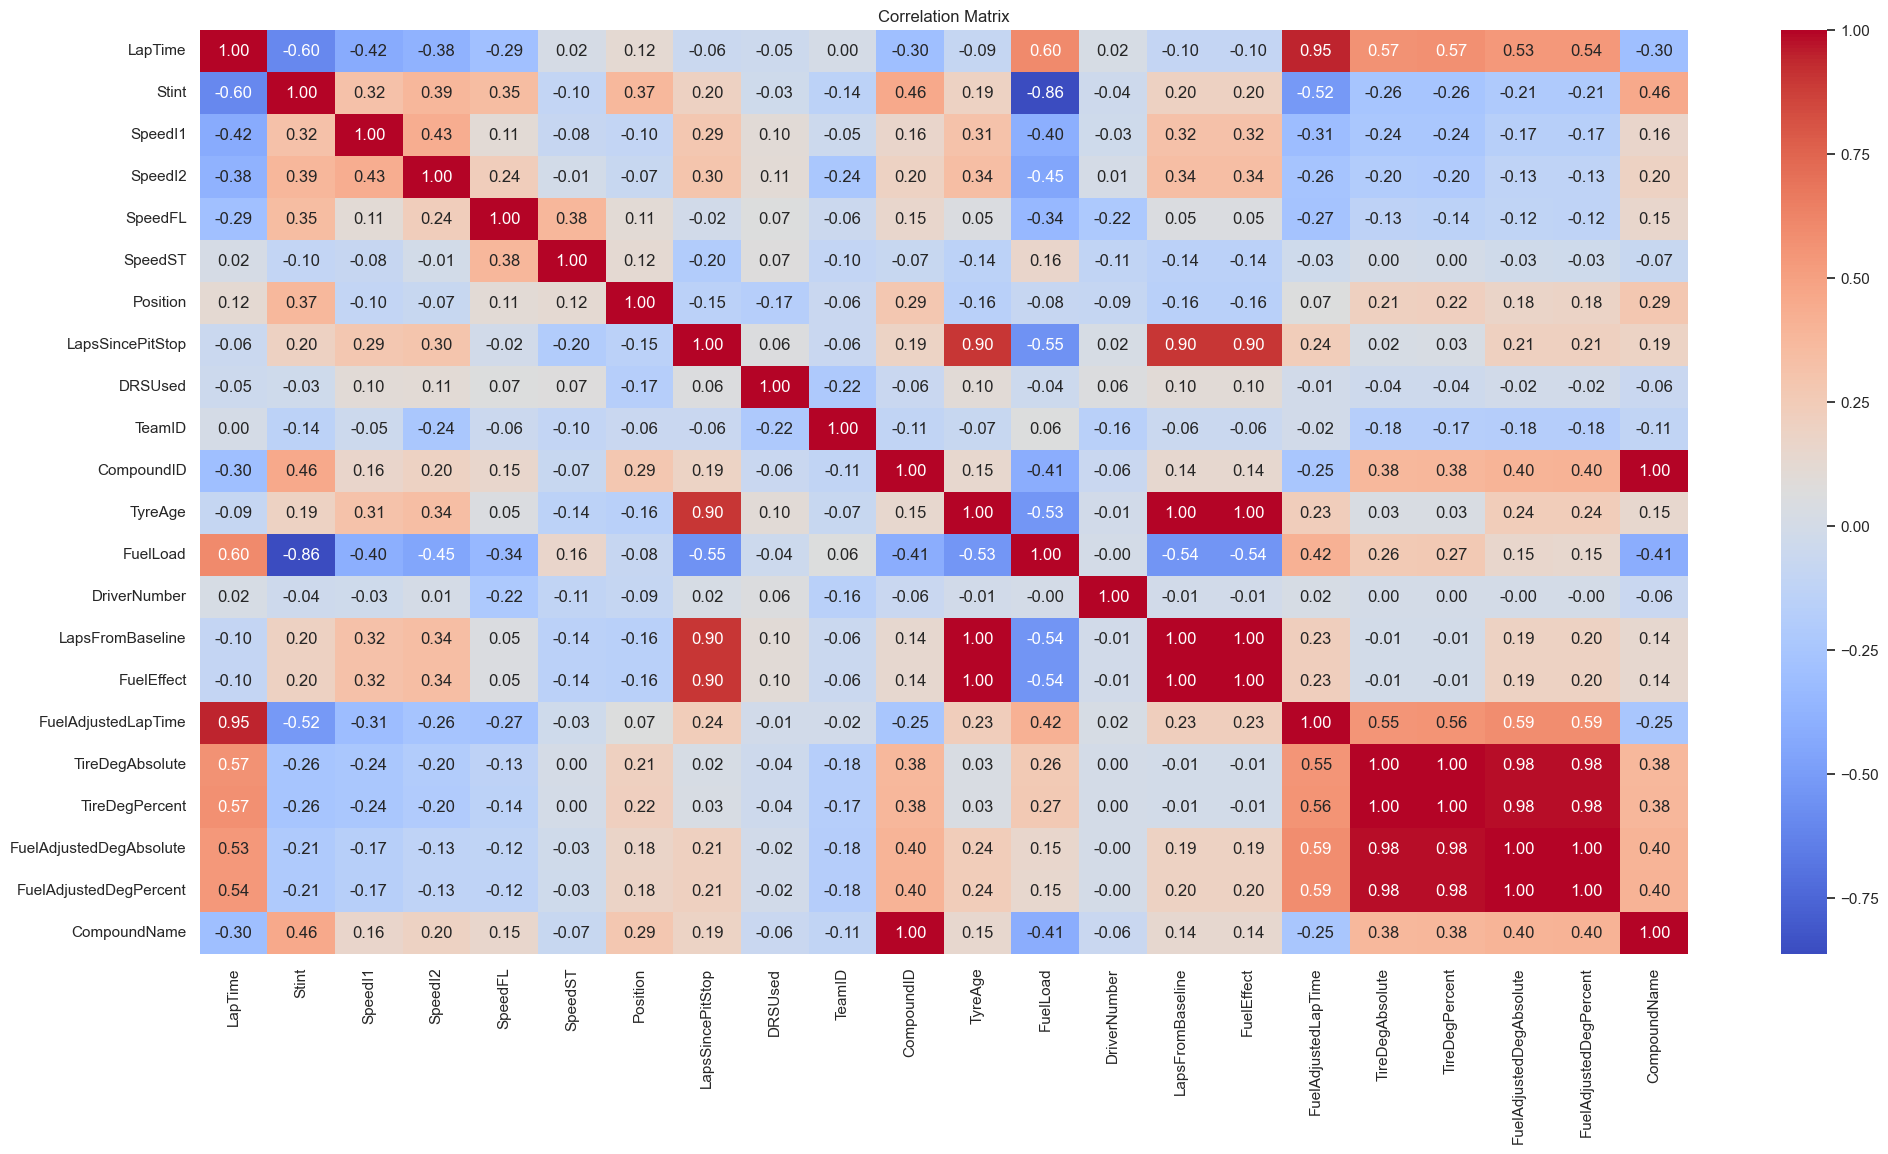

In [88]:
# Making correlation matrix
correlation_matrix = tire_deg_data.corr()

import seaborn as sns
import matplotlib.pyplot as plt

# Crear un heatmap
plt.figure(figsize=(24,12))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

---